In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import numpy as np
from checkpoint_mgr.checkpoint_mgr import CheckpointMgr
from model_design_v2.model_mgr import FaceNetMgr
from eval_utils.inference_api import Inference
import matplotlib.pyplot as plt
pj = os.path.join

In [2]:
infer = Inference(backbone_type='resnet50_irse_mx',
                  ckpt_fpath='/Users/marschen/Ucloud/Project/FaceRecog/model_output/insight_face_res50irsemx_cosface_emore_dist/model_1240.pth',
                  device='cpu')
img_fpath = '../camera_con/test.jpg'
img_fpath = '/Users/marschen/Ucloud/Data/error_analysis/ProblemSet/27_战略发展部-胡维泽/0_register_战略发展部-胡维泽.jpg'


# if os.path.exists(img_fpath):
#     img_cv2 = cv2.imread(img_fpath)
#     embedd = infer.execute(img_cv2)
#     print(embedd)
# else:
#     print('Empty')

LOSS_TYPE: arcface
Active: resnet50_irse_mx
Active: classification
n_no_decay: 256
load_ckpt_fpath: /Users/marschen/Ucloud/Project/FaceRecog/model_output/insight_face_res50irsemx_cosface_emore_dist/model_1240.pth


In [94]:
import math
def format(img_cv2, format_size=112):
    org_h, org_w = img_cv2.shape[0:2]
    rescale_ratio = format_size / max(org_h, org_w)
    h, w = int(org_h * rescale_ratio), int(org_w * rescale_ratio)
    img_rescaled = cv2.resize(img_cv2, (w, h))
    paste_pos = [int((format_size - w)/2), int((format_size - h)/2)]
    img_format = np.zeros((format_size, format_size, 3), dtype=np.uint8)
    img_format[paste_pos[1]:paste_pos[1]+h, paste_pos[0]:paste_pos[0]+w] = img_rescaled
    return img_format

def getX(img_cv2):
    img_cv2 = format(img_cv2)
    img_cv2 = cv2.cvtColor(img_cv2,cv2.COLOR_BGR2RGB)
    img_cv2 = np.transpose(img_cv2, axes=[2, 0, 1])
    img_cv2 = (img_cv2.astype(float)-127.5)/127.5
    img_cv2 = np.expand_dims(img_cv2, axis=0)
    X = torch.FloatTensor(img_cv2)
    return X
    
    

img_fpath = '/Users/marschen/Ucloud/Data/error_analysis/zhongsheng_labeled_update0603/34_技术服务部-韩晨红/0_register_技术服务部-韩晨红.jpg'
img_pos = cv2.imread(img_fpath)
# print(img_pos.shape)
X = getX(img_pos)
X.requires_grad = True 
print(X.shape)
featX,_ = infer.execute2(X)

# img_fpath = '/Users/marschen/Ucloud/Data/error_analysis/zhongsheng_labeled_update0603/34_技术服务部-韩晨红/False/1590253801448_0.478.jpg'
img_fpath = '/Users/marschen/Ucloud/Data/error_analysis/zhongsheng_labeled_update0603/34_技术服务部-韩晨红/True/1590230278567_0.432.jpg'
img_neg = cv2.imread(img_fpath)
Y = getX(img_neg)
Y.requires_grad = True
featY,_ = infer.execute2(Y)

loss = (F.normalize(featX.reshape(-1,1),dim=0)*F.normalize(featY.reshape(-1,1),dim=0)).sum()
print(loss)
loss.backward()

torch.Size([1, 3, 112, 112])
tensor(0.3997, grad_fn=<SumBackward0>)


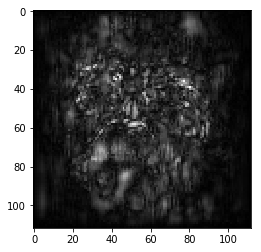

In [93]:
Xg = X.grad.squeeze().permute(1,2,0).data.cpu().numpy()
Xg = np.abs(Xg)
Xg = Xg.sum(2)

def normX(X):
    minX = X.min()
    maxX = X.max()
    return (X-minX)/(maxX-minX)

Xg = normX(Xg)
plt.imshow((Xg*255).astype('uint8'),cmap='gray')

(112, 112, 3)
(112, 112, 3)


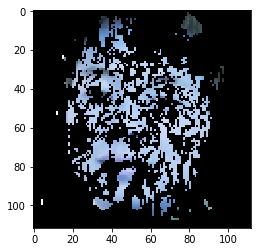

In [95]:
img_pos = format(img_pos)
Xg = Xg > 0.2
Xg = np.stack([Xg,Xg,Xg],axis=2)
print(Xg.shape)
img_pos_plt = img_pos*Xg
print(img_pos_plt.shape)
plt.imshow(img_pos_plt.astype('uint8'))




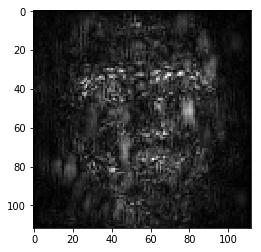

In [97]:
Yg = Y.grad.squeeze().permute(1,2,0).data.cpu().numpy()
Yg = np.abs(Yg)
Yg = Yg.sum(2)

def normX(X):
    minX = X.min()
    maxX = X.max()
    return (X-minX)/(maxX-minX)

Yg = normX(Yg)
plt.imshow((Yg*255).astype('uint8'),cmap='gray')

(112, 112, 3)
(112, 112, 3)


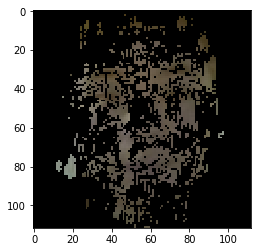

In [98]:
img_neg = format(img_neg)
Yg = Yg > 0.2
Yg = np.stack([Yg,Yg,Yg],axis=2)
print(Yg.shape)
img_neg_plt = img_neg*Yg
print(img_neg_plt.shape)
plt.imshow(img_neg_plt.astype('uint8'))

In [21]:
featX2 = infer.execute(img_pos)
featY2 = infer.execute(img_neg)

featX2 = torch.FloatTensor(featX2).reshape(-1,1)
featX2 = F.normalize(featX2,dim=0)
featY2 = torch.FloatTensor(featY2).reshape(-1,1)
featY2 = F.normalize(featY2,dim=0)

cos_dist = (featX2*featY2).sum()
print(cos_dist)

tensor(0.3368)


In [22]:
featX2

tensor([[-1.5591e-02],
        [-1.6733e-02],
        [-6.4674e-02],
        [-1.6162e-03],
        [-4.4777e-02],
        [ 1.5306e-02],
        [ 5.5967e-03],
        [-2.1960e-02],
        [ 3.9868e-02],
        [ 4.7608e-02],
        [-3.9329e-02],
        [ 1.8969e-04],
        [-2.8165e-02],
        [-2.5385e-02],
        [ 5.6065e-02],
        [ 8.0841e-02],
        [ 6.0585e-04],
        [ 1.8623e-02],
        [-1.2183e-02],
        [-5.4082e-02],
        [ 8.3706e-03],
        [ 1.4950e-02],
        [-3.2204e-02],
        [ 1.1885e-02],
        [ 1.6845e-02],
        [-2.1292e-02],
        [-1.9036e-02],
        [ 1.2434e-01],
        [-2.6217e-02],
        [-1.0750e-01],
        [-6.8022e-02],
        [ 1.5487e-02],
        [ 7.1246e-02],
        [ 1.6612e-02],
        [ 1.0435e-02],
        [-5.6128e-02],
        [ 2.8646e-03],
        [-9.5988e-03],
        [ 9.0702e-05],
        [ 1.2967e-02],
        [ 7.3593e-03],
        [-2.3566e-02],
        [-1.7836e-02],
        [-6

In [3]:
import math
def format(img_cv2, format_size=112):
    org_h, org_w = img_cv2.shape[0:2]
    rescale_ratio = format_size / max(org_h, org_w)
    h, w = int(org_h * rescale_ratio), int(org_w * rescale_ratio)
    img_rescaled = cv2.resize(img_cv2, (w, h))
    paste_pos = [int((format_size - w)/2), int((format_size - h)/2)]
    img_format = np.zeros((format_size, format_size, 3), dtype=np.uint8)
    img_format[paste_pos[1]:paste_pos[1]+h, paste_pos[0]:paste_pos[0]+w] = img_rescaled
    return img_format

##################################################################
class rgbAdj(object):
    def __init__(self,template_path='agg_face.jpg'):
        img_agg = cv2.imread(template_path)
        img_agg = cv2.cvtColor(img_agg,cv2.COLOR_BGR2RGB)
        img_agg = img_agg.astype(float)/255
        self.img_agg = img_agg #0-1,rgb,112
        
    
    def gammaAdj3ch_patch(self,img):
        img_agg = self.img_agg.copy()
        recon_img = np.zeros(img.shape)
        mask_img = np.zeros(img.shape) + 1e-4
        H,W,nCh = recon_img.shape
        assert(H==112 and W==112)
        stride = 14 #112/28 = 4
        patch_sz = 28
        step = math.ceil(H/stride)
        
        for x in range(step):
            for y in range(step):
                w1,w2 = x*stride , min(x*stride+patch_sz,W)
                h1,h2 = y*stride , min(y*stride+patch_sz,H)
                patch = img[h1:h2,w1:w2,:]
                template_patch = img_agg[h1:h2,w1:w2,:]
                
                patch_gamma = self.gammaAdj3ch(patch,img_agg=template_patch,margin=0)
                recon_patch = self.gen_gamma3ch(patch,patch_gamma)
                
                recon_img[h1:h2,w1:w2,:] = recon_img[h1:h2,w1:w2,:] + recon_patch
                mask_img[h1:h2,w1:w2,:] = mask_img[h1:h2,w1:w2,:] + 1
                
        recon_img = recon_img / mask_img
        
        return recon_img
                
            
    def gammaAdj3ch_lmt_patch(self,img):
        img_agg = self.img_agg.copy()
        H,W,nCh = img.shape
        assert(H==112 and W==112)
        min_gamma = 0.35
        stride = 7 #112/28 = 4
        patch_sz = 28
        step = math.ceil(H/stride)
        
        lmda = 1
        recon_imgs = []
        for n in range(nCh):
            recon_img = np.zeros([H,W])
            mask_img = np.zeros([H,W]) + 1e-4
            recon_img_tmp = np.zeros([H,W])
            for x in range(step):
                for y in range(step):
                    w1,w2 = x*stride , min(x*stride+patch_sz,W)
                    h1,h2 = y*stride , min(y*stride+patch_sz,H)
                    patch = img[h1:h2,w1:w2,n]
                    template_patch = img_agg[h1:h2,w1:w2,n]

                    patch_lmt = recon_img_tmp[h1:h2,w1:w2]
                    patch_lmt_mask = patch_lmt > 0
                    patch_lmt_Y = patch_lmt[patch_lmt_mask]
                    patch_lmt_X = patch[patch_lmt_mask]
                    
                    X1 = patch.reshape(-1,1)
                    Y1 = template_patch.reshape(-1,1)
                    
                    X2 = patch_lmt_X.reshape(-1,1)*lmda
                    Y2 = patch_lmt_Y.reshape(-1,1)*lmda
                    
                    X = np.concatenate([X1,X2],axis=0)
                    Y = np.concatenate([Y1,Y2],axis=0)

#                     X = X1
#                     Y = Y1
                    
                    gamma = self._gammaSolver(X,Y)
        
                    if gamma < min_gamma:
                        gamma = min_gamma
            
                    recon_patch = np.power(patch,gamma)

                    recon_img[h1:h2,w1:w2] = recon_img[h1:h2,w1:w2] + recon_patch
                    mask_img[h1:h2,w1:w2] = mask_img[h1:h2,w1:w2] + 1
                    recon_img_tmp = recon_img[:,:] / mask_img[:,:]
            recon_imgs.append(recon_img/mask_img)

        return np.stack(recon_imgs,axis=2)
    
    
    ######################
    def gammaAdj3ch(self,img,img_agg=None,margin=0.25):
        if img_agg is None:
            img_agg = self.img_agg.copy()
        
        #param
        nch = 3
        min_gamma = 0.35
        margin = margin#percentage
        lr = 1
        max_iter = 50
        #input image should be 0-1,rgb,112
        assert(img.shape[2] == nch and img_agg.shape == img.shape )
        #main
        h,w,_ = img.shape
        margin = math.floor(margin*min(h,w))
        
        gammaFunc = lambda x: self._gammaAdj(img[:,:,x],img_agg[:,:,x], margin=margin, lr=lr,max_iter=max_iter)
        gamma = [ max(min_gamma,gammaFunc(i)) for i in range(nch) ]
        return gamma
    
    def gen_gamma3ch(self,img,gamma):
        #img should be 0-1,rgb
        adjimg = np.zeros(img.shape)
        for i,g in enumerate(gamma):
            adjimg[:,:,i] = np.power(img[:,:,i],g)
        return adjimg
         
    
    def _gammaAdj(self,img,img_agg,margin=30,lr=1,max_iter=50):
        h,w = img.shape
        rect_img = img[margin:h-margin,margin:w-margin]
        rect_img_agg = img_agg[margin:h-margin,margin:w-margin]
        X = rect_img.reshape(-1,1)+1e-3
        Y = rect_img_agg.reshape(-1,1)+1e-3
        #L = 1/D*1/2*||X^gamma - Y||_2
        gamma = 1.0
        lnX = np.log(X)
        D = X.shape[0]

        for iter in range(0,max_iter):
            Xg = np.power(X,gamma)
            grad = (Xg - Y)*Xg*lnX
            grad = grad.sum()/D
            gamma = gamma - lr*grad
            
        return gamma
    
    def _gammaSolver(self,X,Y,lr=1,max_iter=50):
        X = X.reshape(-1,1)+1e-3
        Y = Y.reshape(-1,1)+1e-3
        #L = 1/D*1/2*||X^gamma - Y||_2
        gamma = 1.0
        lnX = np.log(X)
        D = X.shape[0]

        for iter in range(0,max_iter):
            Xg = np.power(X,gamma)
            grad = (Xg - Y)*Xg*lnX
            grad = grad.sum()/D
            gamma = gamma - lr*grad
            
        return gamma
    
    #####################
    ######################





In [110]:
datapath = '/Users/marschen/Ucloud/Data/error_analysis/zhongsheng_labeled_update0603/'
lightLib = rgbAdj(template_path='/Users/marschen/jupyter_workspace/Face Recognition/agg_face.jpg')


namefoldlst = os.listdir(datapath)

sim_dict = []

default_folder = 'True'

for namefold in namefoldlst:
#     namefold = namefoldlst[9]
    if namefold.startswith('.') or namefold.startswith('all'):
        continue
    contlst = os.listdir(pj(datapath,namefold))
    reg_name = [c for c in contlst if c.endswith('.jpg')]
    false_name_lst = os.listdir(pj(datapath,namefold,default_folder))
    reg_img = cv2.imread(pj(datapath,namefold,reg_name[0]))
    reg_feat = infer.execute(reg_img)
    reg_feat = torch.FloatTensor(reg_feat).reshape(-1,1)
    reg_feat = F.normalize(reg_feat,dim=0)
    reg_img = format(reg_img)

    reg_img_rgb = cv2.cvtColor(reg_img,cv2.COLOR_BGR2RGB)
    reg_img_rgb = reg_img_rgb.astype(float)/255
    gamma = lightLib.gammaAdj3ch(reg_img_rgb)
    reg_img_rgb = lightLib.gen_gamma3ch(reg_img_rgb,gamma)
    reg_img_rgb = (reg_img_rgb*255).astype('uint8')
    reg_feat2 = infer.execute(cv2.cvtColor(reg_img_rgb,cv2.COLOR_RGB2BGR))
    reg_feat2 = torch.FloatTensor(reg_feat2).reshape(-1,1)
    reg_feat2 = F.normalize(reg_feat2,dim=0)

    prob_feats = []
    for cnt,false_name in enumerate(false_name_lst):
        if false_name.startswith('.'):
            continue
        prob_img = cv2.imread(pj(datapath,namefold,default_folder,false_name))
        prob_feat = infer.execute(prob_img)
        prob_feat = torch.FloatTensor(prob_feat).reshape(-1,1)
        prob_feat = F.normalize(prob_feat,dim=0)
        cos_dist = (reg_feat*prob_feat).sum()

        prob_img = format(prob_img)
        prob_img_rgb = cv2.cvtColor(prob_img,cv2.COLOR_BGR2RGB)
        prob_img_rgb = prob_img_rgb.astype(float)/255
        gamma = lightLib.gammaAdj3ch(prob_img_rgb)
        prob_img_rgb = lightLib.gen_gamma3ch(prob_img_rgb,gamma)
        prob_img_rgb = (prob_img_rgb*255).astype('uint8')
        prob_feat2 = infer.execute(cv2.cvtColor(prob_img_rgb,cv2.COLOR_RGB2BGR))
        prob_feat2 = torch.FloatTensor(prob_feat2).reshape(-1,1)
        prob_feat2 = F.normalize(prob_feat2,dim=0)
        cos_dist2 = (reg_feat2*prob_feat2).sum()

        demo_img = np.concatenate([reg_img,prob_img],axis=1)

#         plt.imshow(cv2.cvtColor(demo_img,cv2.COLOR_BGR2RGB))
        print(cos_dist,cos_dist2)
        sim_dict.append(cos_dist.item())

        savename = '%s-#%d-%1.4f.jpg'%(namefold,cnt,cos_dist.item())
        savepath = pj(datapath,'all_True',savename)
        cv2.imwrite(savepath,demo_img)
#     break
# break

tensor(0.6282) tensor(0.6164)
tensor(0.6122) tensor(0.5882)
tensor(0.4648) tensor(0.4464)
tensor(0.5714) tensor(0.5279)
tensor(0.5483) tensor(0.5285)
tensor(0.5764) tensor(0.4787)
tensor(0.5171) tensor(0.4676)
tensor(0.6293) tensor(0.6015)
tensor(0.4621) tensor(0.4629)
tensor(0.7065) tensor(0.6378)
tensor(0.6960) tensor(0.6783)
tensor(0.6371) tensor(0.6673)
tensor(0.6354) tensor(0.6089)
tensor(0.4921) tensor(0.4790)
tensor(0.4815) tensor(0.4549)
tensor(0.4940) tensor(0.4995)
tensor(0.5758) tensor(0.5707)
tensor(0.7090) tensor(0.7013)
tensor(0.6388) tensor(0.5777)
tensor(0.7175) tensor(0.7073)
tensor(0.6158) tensor(0.6091)
tensor(0.6098) tensor(0.6062)
tensor(0.6766) tensor(0.6724)
tensor(0.7225) tensor(0.7226)
tensor(0.6811) tensor(0.6950)
tensor(0.6533) tensor(0.6576)
tensor(0.5774) tensor(0.5967)
tensor(0.5263) tensor(0.4833)
tensor(0.5401) tensor(0.5102)
tensor(0.5548) tensor(0.5296)
tensor(0.5641) tensor(0.5500)
tensor(0.5487) tensor(0.5363)
tensor(0.4637) tensor(0.4403)
tensor(0.5

tensor(0.4599) tensor(0.4594)
tensor(0.5403) tensor(0.5164)
tensor(0.3650) tensor(0.3688)
tensor(0.3608) tensor(0.3865)
tensor(0.3172) tensor(0.3483)
tensor(0.3446) tensor(0.3540)
tensor(0.3526) tensor(0.3629)
tensor(0.7772) tensor(0.7621)
tensor(0.7159) tensor(0.7042)
tensor(0.5294) tensor(0.5333)
tensor(0.6302) tensor(0.5850)
tensor(0.6682) tensor(0.6447)
tensor(0.5574) tensor(0.5336)
tensor(0.6777) tensor(0.6798)
tensor(0.5636) tensor(0.5548)


In [111]:
len(sim_dict)

289

(array([ 3.,  5., 14., 40., 81., 68., 35., 26., 14.,  3.]),
 array([0.23778383, 0.29434201, 0.35090019, 0.40745836, 0.46401654,
        0.52057471, 0.57713289, 0.63369106, 0.69024924, 0.74680741,
        0.80336559]),
 <a list of 10 Patch objects>)

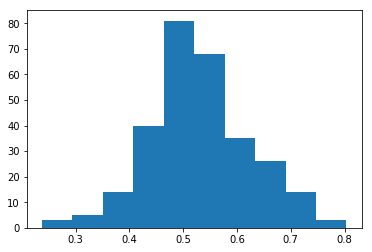

In [112]:
plt.hist(sim_dict)

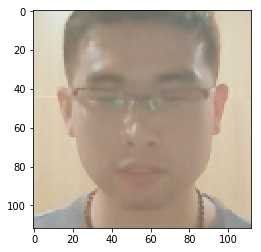

In [90]:
plt.imshow(prob_img_rgb)

In [50]:
x = torch.FloatTensor(reg_feat).reshape(-1,1)
x = F.normalize(x,dim=0)

y = torch.FloatTensor(prob_feats[0]).reshape(-1,1)
y = F.normalize(y,dim=0)

xy = x.transpose(1,0)@y
xy

tensor([[0.3891]])

In [95]:
cos_dist.shape

torch.Size([])